# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import Imputer
import warnings  
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
import category_encoders as ce
le = LabelEncoder()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# Importing Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, test])
data = data.set_index('Instance')
data.replace('nA',np.NaN,inplace=True)
data.drop(['Crime Level in the City of Employement'],inplace=True,axis=1)
data.head()

,Year of Record,Housing Situation,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR]
Instance,,,,,,,,,,,,,,,
1,1940.0,0,17,Unhappy,other,45,Afghanistan,25179,group head,No,1,Black,182,0 EUR,6182.05
2,1940.0,0,4.9,Unhappy,female,17,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,0,Blond,172,0 EUR,6819.69
3,1940.0,0,21,Unhappy,female,48,Afghanistan,822134,sorter,Bachelor,0,Blond,144,0 EUR,8663.53
4,1940.0,0,18,Average,female,42,Albania,59477,quality control senior engineer,No,1,Brown,152,0 EUR,2400.64
5,1940.0,0,8,Happy,other,15,Albania,23494,logistician,Master,1,Black,180,0 EUR,2816.18


In [3]:
data.isnull().sum()

Year of Record                                                5507
Housing Situation                                           170234
Work Experience in Current Job [years]                           0
Satisfation with employer                                    51519
Gender                                                      100435
Age                                                              0
Country                                                          1
Size of City                                                     0
Profession                                                    3894
University Degree                                           109338
Wears Glasses                                                    0
Hair Color                                                   94862
Body Height [cm]                                                 0
Yearly Income in addition to Salary (e.g. Rental Income)         0
Total Yearly Income [EUR]                                   36

# Dealing with Null Values.

In [4]:
data['Year of Record']= data['Year of Record'].fillna(data['Year of Record'].median())
data['Yearly Income in addition to Salary (e.g. Rental Income)'] = data['Yearly Income in addition to Salary (e.g. Rental Income)'].str.replace("EUR","")
data['Total Yearly Income [EUR]']= data['Total Yearly Income [EUR]'].fillna(data['Total Yearly Income [EUR]'].mean())
data['Profession']= data['Profession'].fillna('No Profession')
data['Housing Situation']= data['Housing Situation'].fillna('No House')
data['Country']= data['Country'].fillna('Unknown Country')
data['Satisfation with employer'] = data['Satisfation with employer'].fillna('Unknown')
data['University Degree']= data['University Degree'].fillna('No')
data['Gender'] = data['Gender'].fillna('Unknown')
data['Hair Color'] = data['Hair Color'].fillna('Unknown')
data.isnull().sum()

Year of Record                                              0
Housing Situation                                           0
Work Experience in Current Job [years]                      0
Satisfation with employer                                   0
Gender                                                      0
Age                                                         0
Country                                                     0
Size of City                                                0
Profession                                                  0
University Degree                                           0
Wears Glasses                                               0
Hair Color                                                  0
Body Height [cm]                                            0
Yearly Income in addition to Salary (e.g. Rental Income)    0
Total Yearly Income [EUR]                                   0
dtype: int64

In [5]:
data['Yearly Income in addition to Salary (e.g. Rental Income)'] = data['Yearly Income in addition to Salary (e.g. Rental Income)'].astype(np.float64)

### We will change the Hair Color with value 0 to Red because Red has very less numbers as compared to others

In [6]:
data['Hair Color'] = np.where(data['Hair Color'] == '0', 'Red', data['Hair Color'])
#data['Hair Color'] = np.where(data['Hair Color'] == 'Unknown', 'Red', data['Hair Color'])
data['Hair Color'].value_counts()
#data['Satisfation with employer'].value_counts()

Black      541627
Blond      343679
Brown      343464
Unknown    103340
Red         85902
Name: Hair Color, dtype: int64

In [7]:
data['Gender'] = np.where(data.Gender == 'Unknown', 'unknown', data.Gender)
data['Gender'] = np.where(data.Gender == 'f', 'female', data.Gender)
data['Gender'] = np.where(data.Gender == '0', 'unknown', data.Gender)
data['Gender'].value_counts()

male       541085
female     341211
other      340741
unknown    194975
Name: Gender, dtype: int64

In [8]:
#data['Age'] = np.where(data.Age > 75, 20, data.Age)
#data.Age.value_counts()

In [9]:
data['Housing Situation'] = np.where(data['Housing Situation'] == 0, '0', data['Housing Situation'])
data['Housing Situation'] = np.where(data['Housing Situation'] == '0', 'No House', data['Housing Situation'])
#data['Housing Situation']= data['Housing Situation'].fillna(data['Housing Situation'].mode()[0])
data['Housing Situation'].value_counts()

No House            365345
Large House         212200
Medium House        184710
Castle              170926
Large Apartment     170623
Small House         169785
Medium Apartment    134157
Small Apartment      10266
Name: Housing Situation, dtype: int64

In [10]:
data['University Degree'] = np.where(data['University Degree'] == '0', 'Unknown', data['University Degree'])
data['University Degree']= data['University Degree'].fillna(data['University Degree'].mode()[0])
data['University Degree'].value_counts()

Bachelor    536316
No          449091
Master      339004
PhD          84959
Unknown       8642
Name: University Degree, dtype: int64

In [11]:
data['Work Experience in Current Job [years]'] = np.where(data['Work Experience in Current Job [years]'] == '#NUM!', 12, data['Work Experience in Current Job [years]'])
data['Work Experience in Current Job [years]'] = data['Work Experience in Current Job [years]'].astype(np.float)

# Performing Min-Max Scaler on Numerical Data.

In [13]:
numerical = ['Age','Body Height [cm]','Work Experience in Current Job [years]']
#Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the featuresz
scaler = MinMaxScaler() # default=(0, 1)
data[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
#features_log_minmax_transform = features_log_minmax_transform.drop['Hair Color']
display(data.head(n = 5))

,Year of Record,Housing Situation,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR]
Instance,,,,,,,,,,,,,,,
1,1940.0,No House,0.354167,Unhappy,other,0.276786,Afghanistan,25179,group head,No,1,Black,0.526316,0.0,6182.05
2,1940.0,No House,0.102083,Unhappy,female,0.026786,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,0,Blond,0.473684,0.0,6819.69
3,1940.0,No House,0.437500,Unhappy,female,0.303571,Afghanistan,822134,sorter,Bachelor,0,Blond,0.326316,0.0,8663.53
4,1940.0,No House,0.375000,Average,female,0.250000,Albania,59477,quality control senior engineer,No,1,Brown,0.368421,0.0,2400.64
5,1940.0,No House,0.166667,Happy,other,0.008929,Albania,23494,logistician,Master,1,Black,0.515789,0.0,2816.18


# Using Target Encoding on Categorical Features.

### Reference -> <a href="https://www.kaggle.com/scirpus/target-encoding">Target Encoding Kernal</a>

In [15]:
def add_noise(series, noise_level):
    #Fnction to add noise to the series
    return series * (1 + noise_level * np.random.randn(len(series)))


def targetEncoder(trn_series,tst_series,target):
    #Function to preform Target encoding
    min_samples_leaf=1 
    smoothing=1,
    noise_level=0
    temp = pd.concat([trn_series, target], axis=1)

    #Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])

    #Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))

    #Apply average function to all target data
    prior = target.mean()

    #The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)

    # Apply average
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)

    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])

    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))

    # Apply average function to all target data
    prior = target.mean()

    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)

    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index

    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [16]:
training_dataset = data[:train.shape[0]]
test_dataset = data[train.shape[0]:]
y_train = training_dataset['Total Yearly Income [EUR]']
training_dataset['Housing Situation'],test_dataset['Housing Situation'] = targetEncoder(training_dataset['Housing Situation'],test_dataset['Housing Situation'],y_train)
training_dataset['Satisfation with employer'],test_dataset['Satisfation with employer']= targetEncoder(training_dataset['Satisfation with employer'],test_dataset['Satisfation with employer'],y_train)
training_dataset['Gender'],test_dataset['Gender']= targetEncoder(training_dataset['Gender'],test_dataset['Gender'],y_train)
training_dataset['Country'],test_dataset['Country']= targetEncoder(training_dataset['Country'],test_dataset['Country'],y_train)
training_dataset['Profession'],test_dataset['Profession']= targetEncoder(training_dataset['Profession'],test_dataset['Profession'],y_train)
training_dataset['University Degree'],test_dataset['University Degree']= targetEncoder(training_dataset['University Degree'],test_dataset['University Degree'],y_train)
training_dataset['Hair Color'],test_dataset['Hair Color']= targetEncoder(training_dataset['Hair Color'],test_dataset['Hair Color'],y_train)
#training_dataset['Crime Level in the City of Employement'],test_dataset['Crime Level in the City of Employement']= targetEncoder(training_dataset['Crime Level in the City of Employement'],test_dataset['Crime Level in the City of Employement'],y_train)

In [17]:
#train_df = newdf[:train.shape[0]]
#test_df = newdf[train.shape[0]:]

train_df = training_dataset
test_df = test_dataset

In [18]:
x_test = test_df.drop(['Total Yearly Income [EUR]'],axis=1)

In [19]:
X = train_df.drop('Total Yearly Income [EUR]',axis=1)
y = train_df['Total Yearly Income [EUR]']

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

In [21]:
x_train, x_val_, y_train, y_val = ms.train_test_split(X,y, test_size=0.30, random_state=42)

# LightGBM Model Without K-Fold

In [22]:
# model with LGB
param = {'boosting_type':'gbdt',
'max_depth': -1, 
'learning_rate': 0.07, 
'n_estimators': 90000, 
'early_stopping_rounds': 400,                    
'metric': 'mae',          
'boosting_type': 'gbdt'}
train_set = lgb.Dataset(x_train, y_train)
val_set = lgb.Dataset(x_val_, label=y_val)
model = lgb.train(param, train_set, valid_sets=val_set, verbose_eval=1000)

Training until validation scores don't improve for 400 rounds.
[1000]	valid_0's l1: 9270.06
[2000]	valid_0's l1: 8987.2
[3000]	valid_0's l1: 8851.21
[4000]	valid_0's l1: 8760.17
[5000]	valid_0's l1: 8694.35
[6000]	valid_0's l1: 8641.84
[7000]	valid_0's l1: 8613.49
[8000]	valid_0's l1: 8585.61
[9000]	valid_0's l1: 8563.83
[10000]	valid_0's l1: 8545.69
[11000]	valid_0's l1: 8527.67
[12000]	valid_0's l1: 8519.19
[13000]	valid_0's l1: 8511.56
[14000]	valid_0's l1: 8497.32
[15000]	valid_0's l1: 8490.35
[16000]	valid_0's l1: 8482.89
[17000]	valid_0's l1: 8477.56
[18000]	valid_0's l1: 8474.04
[19000]	valid_0's l1: 8468.53
[20000]	valid_0's l1: 8465.95
[21000]	valid_0's l1: 8464.05
[22000]	valid_0's l1: 8458.05
Early stopping, best iteration is:
[22208]	valid_0's l1: 8455.79


"Training until validation scores don't improve for 400 rounds.\n[1000]\tvalid_0's l1: 9364.29\n[2000]\tvalid_0's l1: 9100.61\n[3000]\tvalid_0's l1: 8972.43\n[4000]\tvalid_0's l1: 8907.1"

In [23]:
test_pred = model.predict(x_test)

In [24]:
test_pred = model.predict(x_test)
test_df['Total Yearly Income [EUR]'] =  test_pred
test_df.to_csv('26th.csv', columns = ['Total Yearly Income [EUR]'])
test_df['Total Yearly Income [EUR]']

Instance
1          35155.163275
2           7734.230127
3           3328.287474
4          84168.369696
5           3433.694100
6           9536.364479
7          44387.748800
8           4571.869644
9         158605.500632
10         63957.257396
11         14784.720183
12        388778.099233
13           422.755799
14          9496.348176
15          3586.230413
16          3790.850635
17          2556.522143
18        127893.137705
19         23036.990196
20        310324.105123
21           648.051883
22         10949.772503
23          1600.900691
24         18189.699729
25         26688.936966
26          6030.892902
27          7087.048839
28         40545.383710
29        263284.003011
30          4194.054765
              ...      
369409      3998.819650
369410     -4291.383058
369411    213553.073208
369412    166955.574431
369413     36260.677402
369414    163491.247347
369415      6033.405081
369416    114923.145737
369417     33246.050562
369418     39403.141745
369419 

# LGBM Model with K-Fold

In [313]:
# model with LGB
# K-fold corss validation with 10 fold
n_splits = 15
kf = KFold(n_splits=n_splits)
# separate target column and feature columns
labels = train_df.pop('Total Yearly Income [EUR]')
data = train_df
       
param = {'objective': 'regression', 'metric': 'mae', 'learning_rate': 0.04, 
         "bagging_seed": 11,
         "boosting": "gbdt",
         'early_stopping_rounds':600,
         'num_rounds': 40000, 'verbose': 1}
test_pred = np.zeros(len(test_df))
for fold, (train_indx, val_indx) in enumerate(kf.split(labels)):
    print("Fold {}".format(fold+1))
    train_set = lgb.Dataset(data.iloc[train_indx], label=labels.iloc[train_indx])
    val_set = lgb.Dataset(data.iloc[val_indx], label=labels.iloc[val_indx])
    model = lgb.train(param, train_set, valid_sets=val_set, verbose_eval=5000)
    test_pred += model.predict(x_test)/n_splits

Fold 1
Training until validation scores don't improve for 600 rounds.
[5000]	valid_0's l1: 1027.83
[10000]	valid_0's l1: 845.179
[15000]	valid_0's l1: 773.784
[20000]	valid_0's l1: 735.215
[25000]	valid_0's l1: 701.893
Early stopping, best iteration is:
[27259]	valid_0's l1: 684.6
Fold 2
Training until validation scores don't improve for 600 rounds.
[5000]	valid_0's l1: 848.53
[10000]	valid_0's l1: 758.318
[15000]	valid_0's l1: 706.329
Early stopping, best iteration is:
[18011]	valid_0's l1: 679.04
Fold 3
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[163]	valid_0's l1: 1366.65
Fold 4
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[126]	valid_0's l1: 1658.52
Fold 5
Training until validation scores don't improve for 600 rounds.
Early stopping, best iteration is:
[129]	valid_0's l1: 1785.61
Fold 6
Training until validation scores don't improve for 600 rounds.
[5000]	valid_0's l1: 1843.6

"Fold 1\nTraining until validation scores don't improve for 600 rounds.\n[5000]\tvalid_0's l1: 1061.6\n[10000]\tvalid_0's l1: 891.326\nEarly stopping, best iteration is:\n[11521]\tvalid_0's l1: 865.505"

In [314]:
test_df['Total Yearly Income [EUR]'] =  test_pred
test_df.to_csv('KFoldV2.csv', columns = ['Total Yearly Income [EUR]'])
test_df['Total Yearly Income [EUR]']

Instance
1          37220.920517
2           7344.671657
3           3292.225776
4          79576.684459
5           3943.025486
6           8182.907169
7          50436.211192
8           5141.109605
9         165595.697811
10         68500.228902
11         14373.335862
12        368222.978769
13           235.196336
14          9321.686350
15          4484.797711
16          5104.314646
17          4059.383764
18        127879.042769
19         23995.360010
20        300786.640967
21          2087.847334
22          9583.447408
23          2317.289813
24         18663.910091
25         25354.511848
26          7300.389420
27          7600.082045
28         38661.207294
29        244578.875067
30          5771.810119
              ...      
369409      4522.025325
369410     11799.585853
369411    226559.561623
369412    165095.676769
369413     35996.323734
369414    162810.312740
369415      8075.434983
369416    129051.058028
369417     36438.112362
369418     40647.919182
369419 

# Using Ensembled Stacked Modeling Technique.
#### Here we are going to taked weighted average (as per mean absolute error score) o LGBM, LGBM with K-Fold and XGBOOST Models which performed very well on public leaderboard.

### Reference -> <a href="https://www.kaggle.com/amar09/fare-prediction-stacked-ensemble-xgboost-lgbm">Stacked Ensemble Technique Kernal</a>

##### We Will Select the Top 3 Best Performing Scores currenly on our Public Leaderboard.

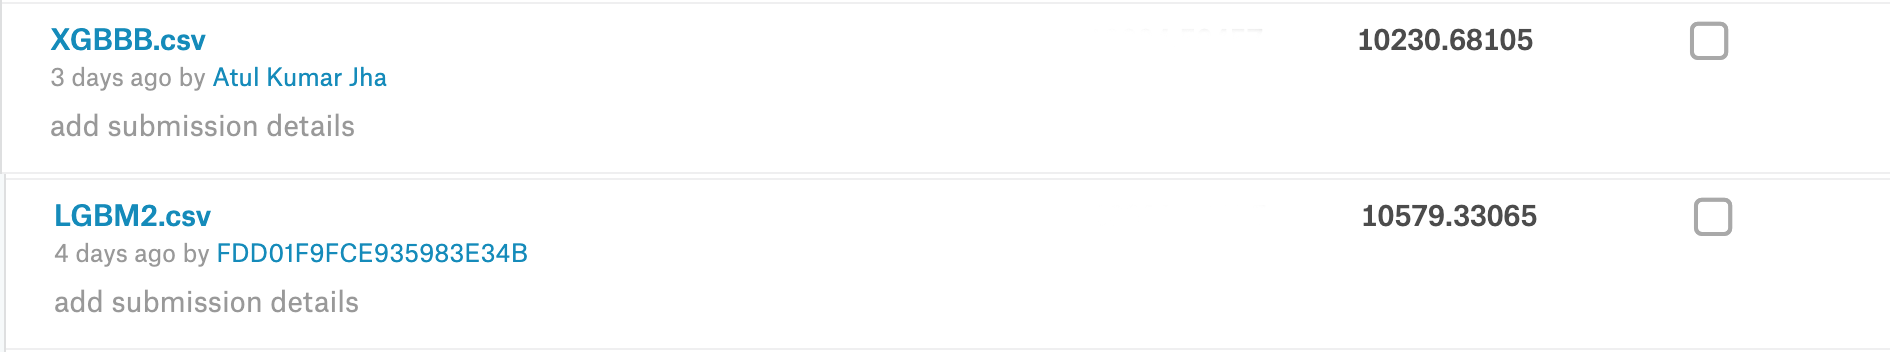

In [1]:
from IPython.display import Image
Image("selected.png")

In [41]:
# Selecting 10500 MAE File
lgbm2 = pd.read_csv('LGBM2.csv')
lgbm2 = lgbm2['Total Yearly Income [EUR]'].values

# Selecting 10230 MAE File
xgbb = pd.read_csv('XGBBB.csv')
xgbb = xgbb['Total Yearly Income [EUR]'].values

# Selecting 10230 MAE File
recent = pd.read_csv('26th.csv')
recent = recent['Total Yearly Income [EUR]'].values

ensembled_prediction = (4.*xgbb)+(0.3*lgbm2)+(0.3*recent)
en_sub = pd.DataFrame({'Instance': x_test.index, 'Total Yearly Income [EUR]': ensembled_prediction}, index=None)
en_sub.head(15)
en_sub.to_csv('StackedV2.csv')